# MACHINE LEARNING ASSESMENT
Below is an analysis on the purchasing intentions of users on an e-commerce website. This analysis is to be viewed in conjunction with the report. There are brief explanations of each section, as well as graphical representations that may not necessarily appear in the accompanying report. All sections are numbered and summarised in the table of contents below. All relevant references to this notebook are made in the report. Furthermore, the below code has been tested with the file `e-commerce_data.csv` and is fully functional.

## Table Of Contents
1. Understanding The Data
        1.1. Overview of Data Columns
        1.2. Overview of Column Values
        1.3. Splitting The Data Into Test and Training Set
2. Analysis of Training Data
        2.1. Categorical Feature Analysis
            2.1.1 Stratified Sampling Checker
            2.1.2 Visual Representation of Categorical Features
            2.1.3 Categorical Feature Relevance
                2.1.3.1 Chi-Squared
        2.2. Numerical Feature Analysis
            2.1.1 Data Relationships
            2.1.2 Statistical Summary
            2.1.3 Numerical Feature Relevance
                2.1.3.1 Kendall Tau Coefficient
                2.1.3.2 ANOVA F-Statistic
3. Data Pre-Proccesing
        3.1. Preparing The Data
        3.2. Principal Component Analysis
4. Model Implementation
        4.1. Classification Models
            4.1.1 Logistical Regression Model
            4.1.2 Support Vector Machine Model
            4.1.3 Random Forest Classification
        4.2. Hyperparamter Optimisation
            4.2.1 Random Search Analysis
            4.2.3 Grid Search Analysis
        4.3. Trained Model Testing
5. Evaluate Model Performance

In [1]:
# pip install -U imbalanced-learn
import warnings
warnings.simplefilter("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

ecomm = pd.read_csv('e-commerce_data.csv')

## 1. Understanding The Data
Here we have an initial look at the data to try get a feel of the dataset, and to do a brief initial investigation to get a better understanding around the dimensionality of the data or if there are any missing values etc.

In [2]:
ecomm.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


### 1.1. Overview of Data Columns

In [3]:
print('INFORMATION ON THE E-COMMERCE DATA SET:')
print(ecomm.info())
print('\n\nCOLUMNS IN THE E-COMMERCE DATA SET:\n',ecomm.columns)

INFORMATION ON THE E-COMMERCE DATA SET:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-n

### 1.2. Overview of Column Values

In [4]:
print('\n\nNUMBER OF UNIQUE VALUES IN THE E-COMMERCE DATA SET:\n', ecomm.nunique())
print('\nNUMBER OF NaN VALUES:\n',ecomm.isna().sum())
print('\n\nUNIQUE VALUES IN THE E-COMMERCE DATA SET:\n')
for col in ecomm:
    print('{}:{}\n'.format(col.upper(),ecomm[col].unique()))
print('\n\n')
for col in ecomm:
    print('{}:\n{}\n'.format(col.upper(),ecomm[col].value_counts(normalize=True)))



NUMBER OF UNIQUE VALUES IN THE E-COMMERCE DATA SET:
 Administrative               27
Administrative_Duration    3335
Informational                17
Informational_Duration     1258
ProductRelated              311
ProductRelated_Duration    9551
BounceRates                1872
ExitRates                  4777
PageValues                 2704
SpecialDay                    6
Month                        10
OperatingSystems              8
Browser                      13
Region                        9
TrafficType                  20
VisitorType                   3
Weekend                       2
Revenue                       2
dtype: int64

NUMBER OF NaN VALUES:
 Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSyst

### 1.3. Splitting the Data into a Test And Training Data Set
There is debate on when data should be split, however splitting the data before analysis allows a more fair approach. This is the suggested methodology by Géron in *Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, 
Tools, and Techniques to Build Intelligent Systems*.

After splitting the data, we ensure that the training and test data sets are of sufficient size. We then investigate the representation of each Revenue class, and note that there is a drastic imbalance between False and True 'Revenue' values. This indicates that we have imbalanced data.

In [18]:
# Seperate the Revenue feature from the other attributes
ecomm_x = ecomm.drop('Revenue', axis=1)
ecomm_y = ecomm['Revenue']

#Split the Data and ensure that the split is consistenet with the Original Data
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(ecomm_x, ecomm_y, test_size=0.3, shuffle=True)
print('IN THE TRAINING DATA SET THERE ARE:\n')
print('- {} x-Values'.format(len(x_train)))
print('- {} y-Values'.format(len(y_train)))
print ('Revenue Class Breakdown is as follows:\n', round(y_train.value_counts(normalize=True),2))
print('\n\nIN THE TEST DATA SET THERE ARE:\n')
print('- {} x-Values'.format(len(x_test)))
print('- {} y-Values'.format(len(y_test)))
print ('Revenue Class Proportional Split is as follows:\n', round(y_test.value_counts(normalize=True),2))

# Join the features and target feature together for the purpose of our analysis
ecomm_train = x_train.join(y_train)

IN THE TRAINING DATA SET THERE ARE:

- 8631 x-Values
- 8631 y-Values
Revenue Class Breakdown is as follows:
 False    0.84
True     0.16
Name: Revenue, dtype: float64


IN THE TEST DATA SET THERE ARE:

- 3699 x-Values
- 3699 y-Values
Revenue Class Proportional Split is as follows:
 False    0.86
True     0.14
Name: Revenue, dtype: float64


## 2. Analysis of Training Data 

### 2.1. Categorical Feature Analysis

#### 2.1.1. Stratified Sampling Checker
Here we are investigating subcategories within each categorical feature in the training data set. We need to ensure that each category is fairly represented and consistent with the original data set. As we can see there are minimal differences between the strata of each categorical feature, which indicates that our training set is a fair representation of the original dataset.

In [19]:
# Creating a dictionary that shows the original data categorical feature proportions
sday_od = ecomm['SpecialDay'].value_counts(normalize=True)
month_od = ecomm['Month'].value_counts(normalize=True)
os_od = ecomm['OperatingSystems'].value_counts(normalize=True)
browser_od = ecomm['Browser'].value_counts(normalize=True)
region_od = ecomm['Region'].value_counts(normalize=True)
trafict_od = ecomm['TrafficType'].value_counts(normalize=True)
visitor_od = ecomm['VisitorType'].value_counts(normalize=True)
wkend_od = ecomm['Weekend'].value_counts(normalize=True)
rev_od = ecomm['Revenue'].value_counts(normalize=True)

od_dic = {'SpecialDay': sday_od, 'Month': month_od, 'OperatingSystems': os_od, 'Browser': browser_od,
           'Region': region_od, 'TrafficType': trafict_od, 'VisitorType': visitor_od,
           'Weekend': wkend_od,'Revenue': rev_od}

# Creating a dictionary that shows the test set data categorical feature proportions
sday_td = x_train['SpecialDay'].value_counts(normalize=True)
month_td = x_train['Month'].value_counts(normalize=True)
os_td = x_train['OperatingSystems'].value_counts(normalize=True)
browser_td = x_train['Browser'].value_counts(normalize=True)
region_td = x_train['Region'].value_counts(normalize=True)
trafict_td = x_train['TrafficType'].value_counts(normalize=True)
visitor_td = x_train['VisitorType'].value_counts(normalize=True)
wkend_td = x_train['Weekend'].value_counts(normalize=True)
rev_td = y_train.value_counts(normalize=True)
td_dic = {'SpecialDay': sday_td, 'Month': month_td, 'OperatingSystems': os_td, 'Browser': browser_td,
           'Region': region_td, 'TrafficType': trafict_td, 'VisitorType': visitor_td,
           'Weekend': wkend_td,'Revenue': rev_td}

# Finding the difference between the two dictionaries, ensuring that the each of the strata within the categories is fairly represented
diff_n = pd.DataFrame({key: sum(od_dic[key] - td_dic.get(key, 0)) for key in od_dic}, index=[0])
diff = diff_n.sum(axis=1)
print('DIFFERENCES BETWEEN PROPORTIONALITY OF DATA PER CATEGORY:\n', diff_n)
print('\n\nOVERALL DIFFERENCE OF PROPORTIONALITY FOR ALL CATEGORIES:\n',diff)

DIFFERENCES BETWEEN PROPORTIONALITY OF DATA PER CATEGORY:
      SpecialDay         Month  OperatingSystems       Browser        Region  \
0 -7.459311e-17 -3.295975e-17     -5.838429e-17  8.456777e-18 -3.469447e-17   

    TrafficType   VisitorType       Weekend       Revenue  
0  4.033232e-17  4.683753e-17  2.775558e-17  2.775558e-17  


OVERALL DIFFERENCE OF PROPORTIONALITY FOR ALL CATEGORIES:
 0   -4.949383e-17
dtype: float64


#### 2.1.2. Visual Representations Of Categorical Features
This subsection breaks each categorical feature down into their subcategories and shows the proportion of each categorical strata that resulted in 'True' or 'False' Revenue intentions.

<AxesSubplot:title={'center':'Weekend System'}>

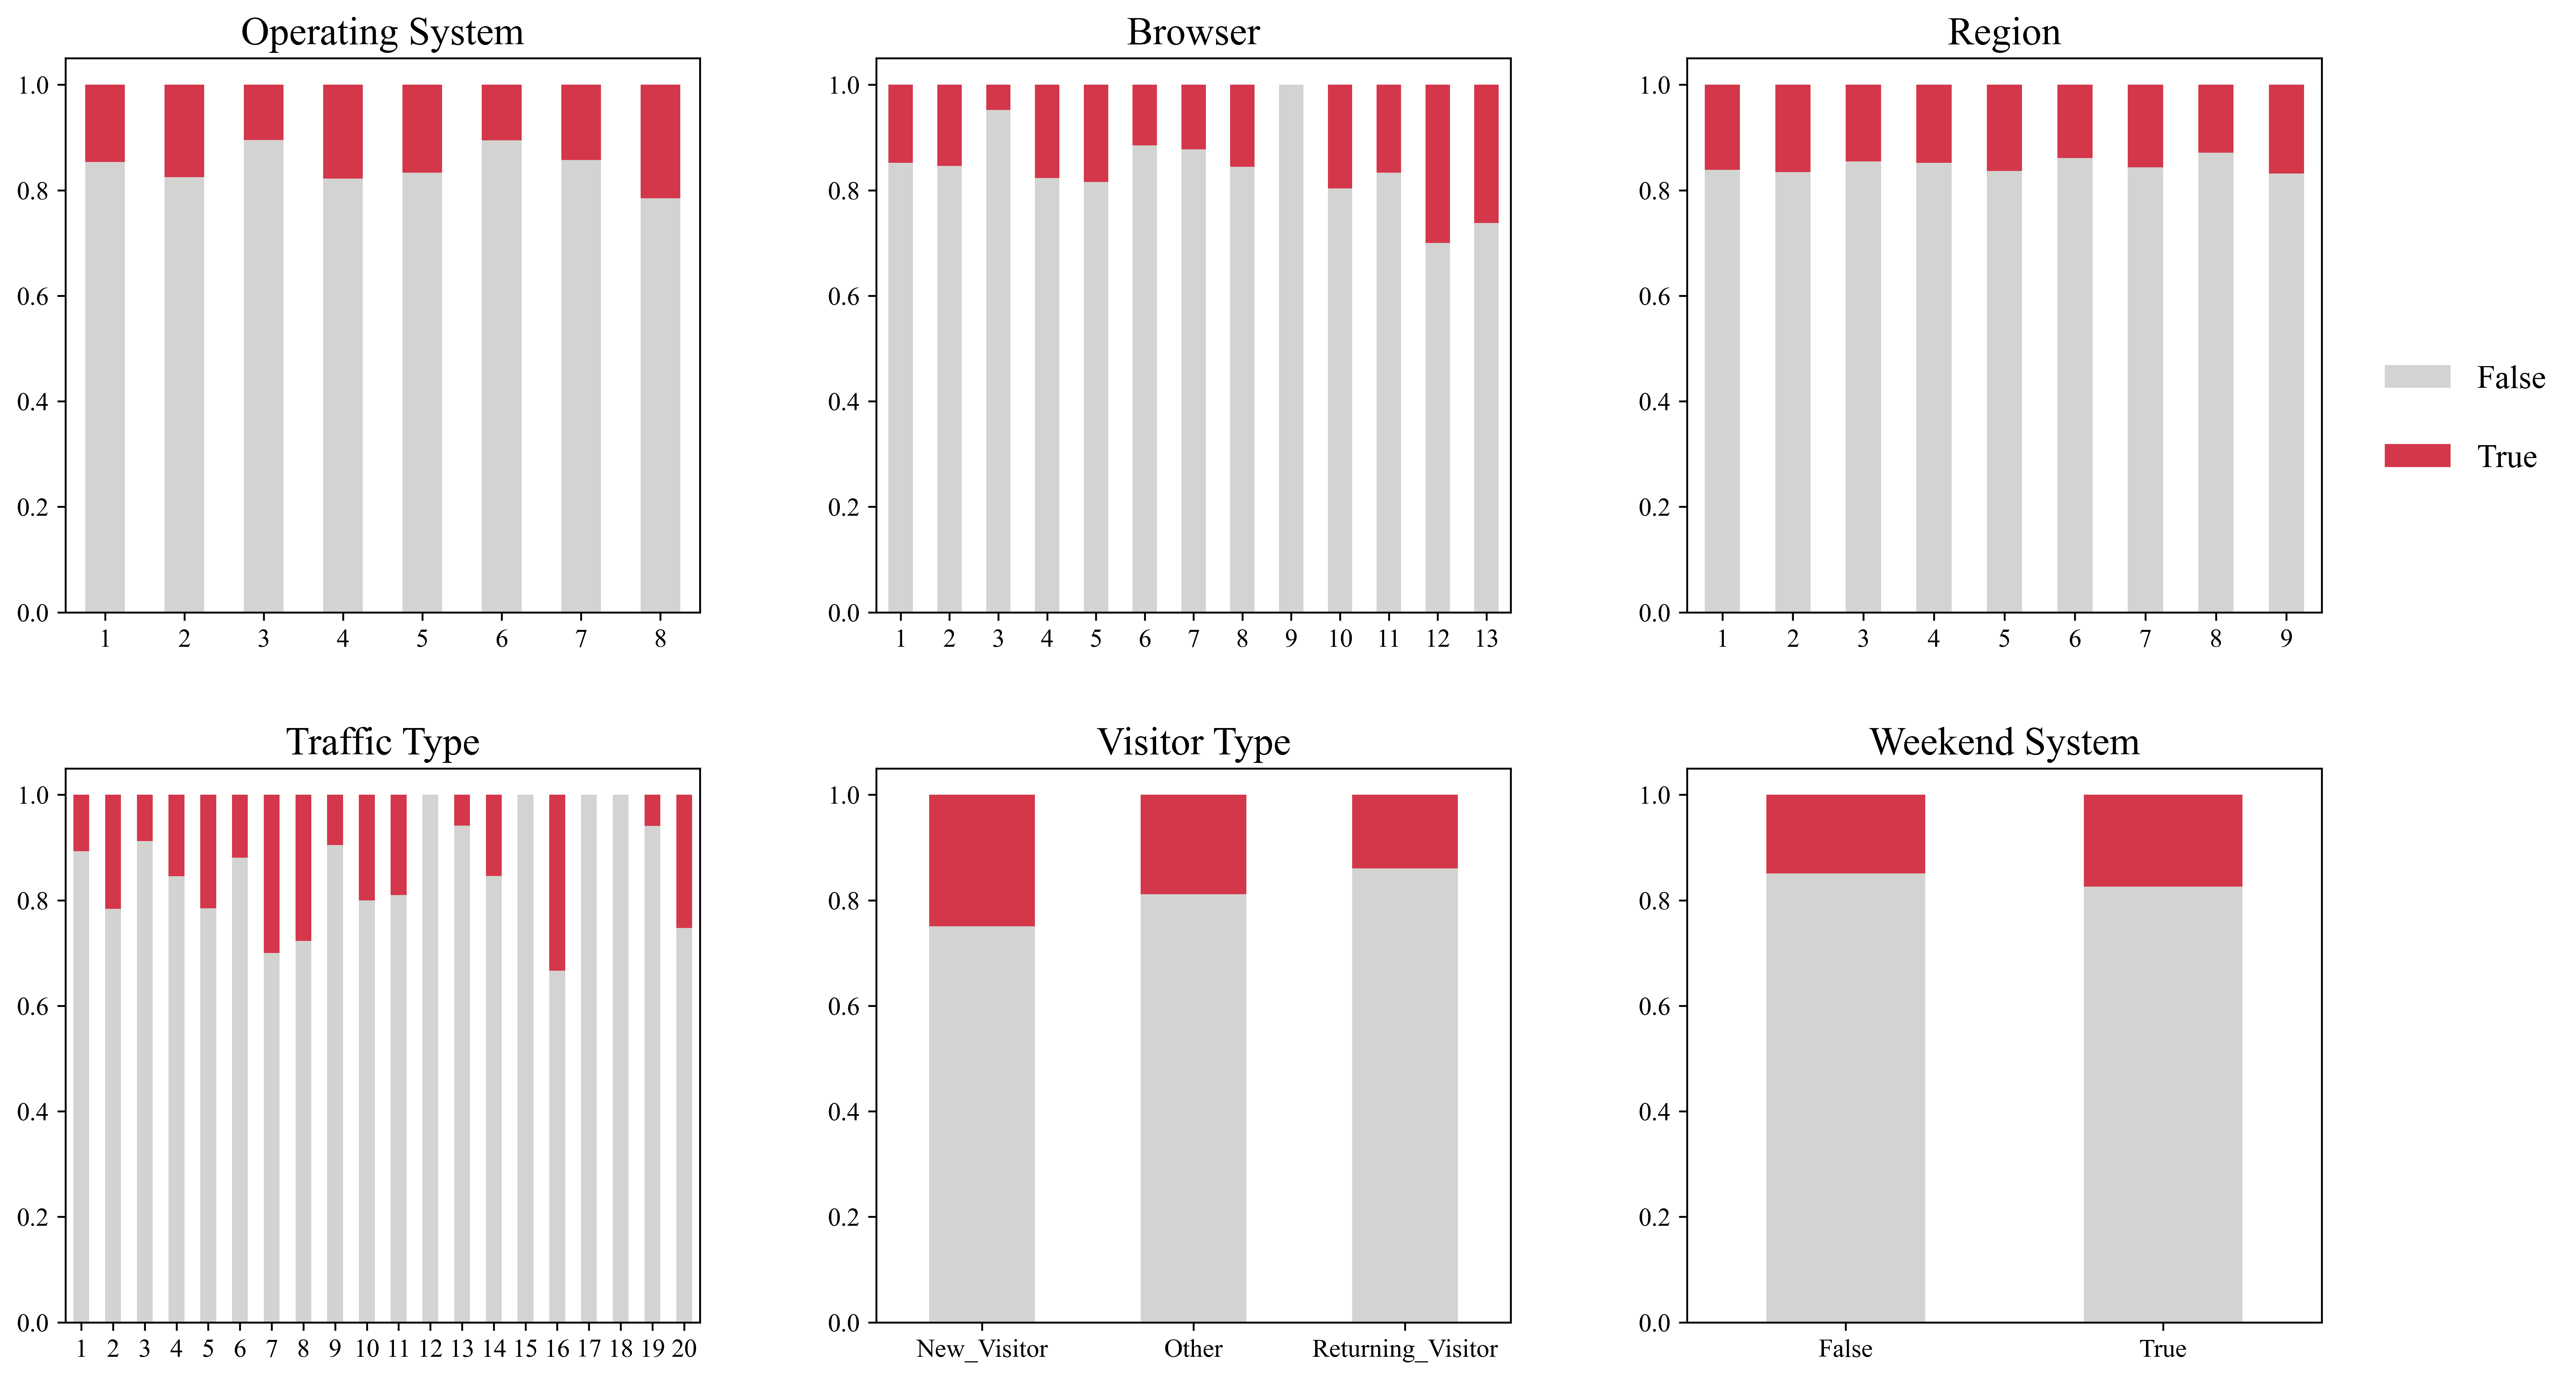

In [7]:
# Set font and font size
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 14

# Create plots for categorical features
fig, ax = plt.subplots(2, 3, figsize=(15,9), dpi=600)
fig.tight_layout(pad=3)

test = pd.crosstab(ecomm['OperatingSystems'], ecomm['Revenue'], normalize='index')
test.plot(ax = ax[0][0], kind='bar', stacked=True, legend=False, title = 'Operating System', xlabel= '', fontsize=11, rot=0, color = ['#d3d3d2','#d4374a'])

test1 = pd.crosstab(ecomm['Browser'], ecomm['Revenue'], normalize='index')
test1.plot(ax = ax[0][1], kind='bar', stacked=True, legend=False, title = 'Browser', xlabel= '', fontsize=11, rot=0, color = ['#d3d3d2','#d4374a'])

test2 = pd.crosstab(ecomm['Region'], ecomm['Revenue'], normalize='index')
test2.plot(ax = ax[0][2], kind='bar', stacked=True, title = 'Region', xlabel= '', fontsize=11, rot=0, color = ['#d3d3d2','#d4374a'])
ax[0][2].legend(fontsize = 14, frameon=False, bbox_to_anchor=(0.9, 0., 0.5, 0.5), labelspacing=1.5)

test3 = pd.crosstab(ecomm['TrafficType'], ecomm['Revenue'], normalize='index')
test3.plot(ax = ax[1][0], kind='bar', stacked=True, legend=False, title = 'Traffic Type', xlabel= '', fontsize=11, rot=0, color = ['#d3d3d2','#d4374a'])

test4 = pd.crosstab(ecomm['VisitorType'], ecomm['Revenue'], normalize='index')
test4.plot(ax = ax[1][1], kind='bar', stacked=True, legend=False, title = 'Visitor Type', xlabel= '', fontsize=11, rot=0, color = ['#d3d3d2','#d4374a'])

test5 = pd.crosstab(ecomm['Weekend'], ecomm['Revenue'], normalize='index')
test5.plot(ax = ax[1][2], kind='bar', stacked=True, legend=False, title = 'Weekend System', xlabel= '', fontsize=11, rot=0, color = ['#d3d3d2','#d4374a'])

# plt.savefig('CategoricalVisuals', bbox_inches = "tight")

<AxesSubplot:title={'center':'Month'}>

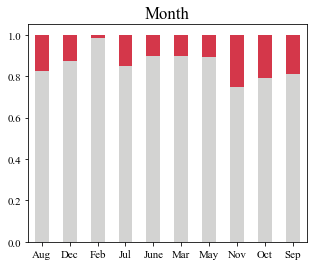

In [8]:
# Set font and font size
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 14

# Create plot for categorical feature
fig, ax = plt.subplots(1, 1, figsize=(5,4))

test = pd.crosstab(ecomm['Month'], ecomm['Revenue'], normalize='index')
test.plot(ax = ax, kind='bar', stacked=True, legend=False, title = 'Month', xlabel= '', fontsize=11, rot=0, color = ['#d3d3d2','#d4374a'])

# plt.savefig('Month', bbox_inches = "tight")

#### 2.1.3. Categorical Feature Relevance

To analyse categorical features, we will utilise the SelectKBest functionality from Scikit-Learn. We will then use an ordinal encoder to transform the categorical features and a label encoder to transform the target feature. Once we have used the OrdinalEncoder on the categorical features, the feature numbers represent the following features from the training dataset:
- Feature 0: `OperatingSystems`
- Feature 1: `Browser`
- Feature 2: `Region`
- Feature 3: `TrafficType`
- Feature 4: `VisitorType`
- Feature 5: `Weekend`
- Feature 6: `Month`

In [20]:
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.feature_selection import SelectKBest

# Create a seperate dataframes to deal with Categorical Data
ecomm_train_c = ecomm_train[['OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType','Weekend','Month']]

#Encode the Categorical data ordinally
oe = OrdinalEncoder()
x_train_enc = pd.DataFrame(oe.fit_transform(ecomm_train_c))

#Encde the
le = LabelEncoder()
y_train_enc = pd.DataFrame(le.fit_transform(y_train))

##### 2.1.3.1. Chi-Squared
Using a Chi-Squared feature selection approach, we can determine which categorical features are independent of the target variable, and they can then be removed. The higher the value of the test statistic and the lower the associated p-value, the more relevant the feature.

Feature 0:
	Chi-Squared Score: 0.530024
	P-Value: 0.46659662816312
Feature 1:
	Chi-Squared Score: 4.561527
	P-Value: 0.032697904106677465
Feature 2:
	Chi-Squared Score: 2.144186
	P-Value: 0.14311095166212726
Feature 3:
	Chi-Squared Score: 2.815814
	P-Value: 0.0933395326592638
Feature 4:
	Chi-Squared Score: 32.949360
	P-Value: 9.45908566837439e-09
Feature 5:
	Chi-Squared Score: 6.483454
	P-Value: 0.010888318614684034
Feature 6:
	Chi-Squared Score: 61.719777
	P-Value: 3.95982966503183e-15


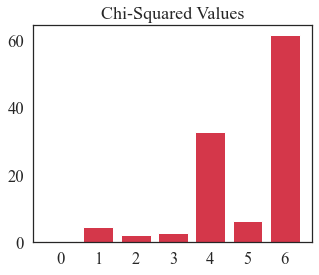

In [21]:
from sklearn.feature_selection import chi2

# Here we use the 'chi2' functionality to determine the most relevant features
fs_c = SelectKBest(score_func=chi2, k='all')
fs_c.fit_transform(x_train_enc, y_train_enc)

# Creating a grapical representation
for i in range(len(fs_c.scores_)):
    print('Feature %d:' % (i))
    print('\tChi-Squared Score: %f' % (fs_c.scores_[i]))
    print('\tP-Value:', (fs_c.pvalues_[i]))
    
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 14

fig, ax = plt.subplots(1, 1, figsize=(5,4))
ax.bar([i for i in range(len(fs_c.scores_))], fs_c.scores_, color='#d4374a')
ax.set_title('Chi-Squared Values')
plt.xticks([0,1,2,3,4,5,6])

plt.show()
# fig.savefig('ChiSquared', bbox_inches = "tight")

### 2.2. Numerical Feature Analysis

#### 2.2.1. Data Relationships
Here we investigate the relationships that the features share, split between the `Revenue` class. From the graphs below the relationship does not appear to be linear, which indicated to us that we may need to utilise polynomials in our model.

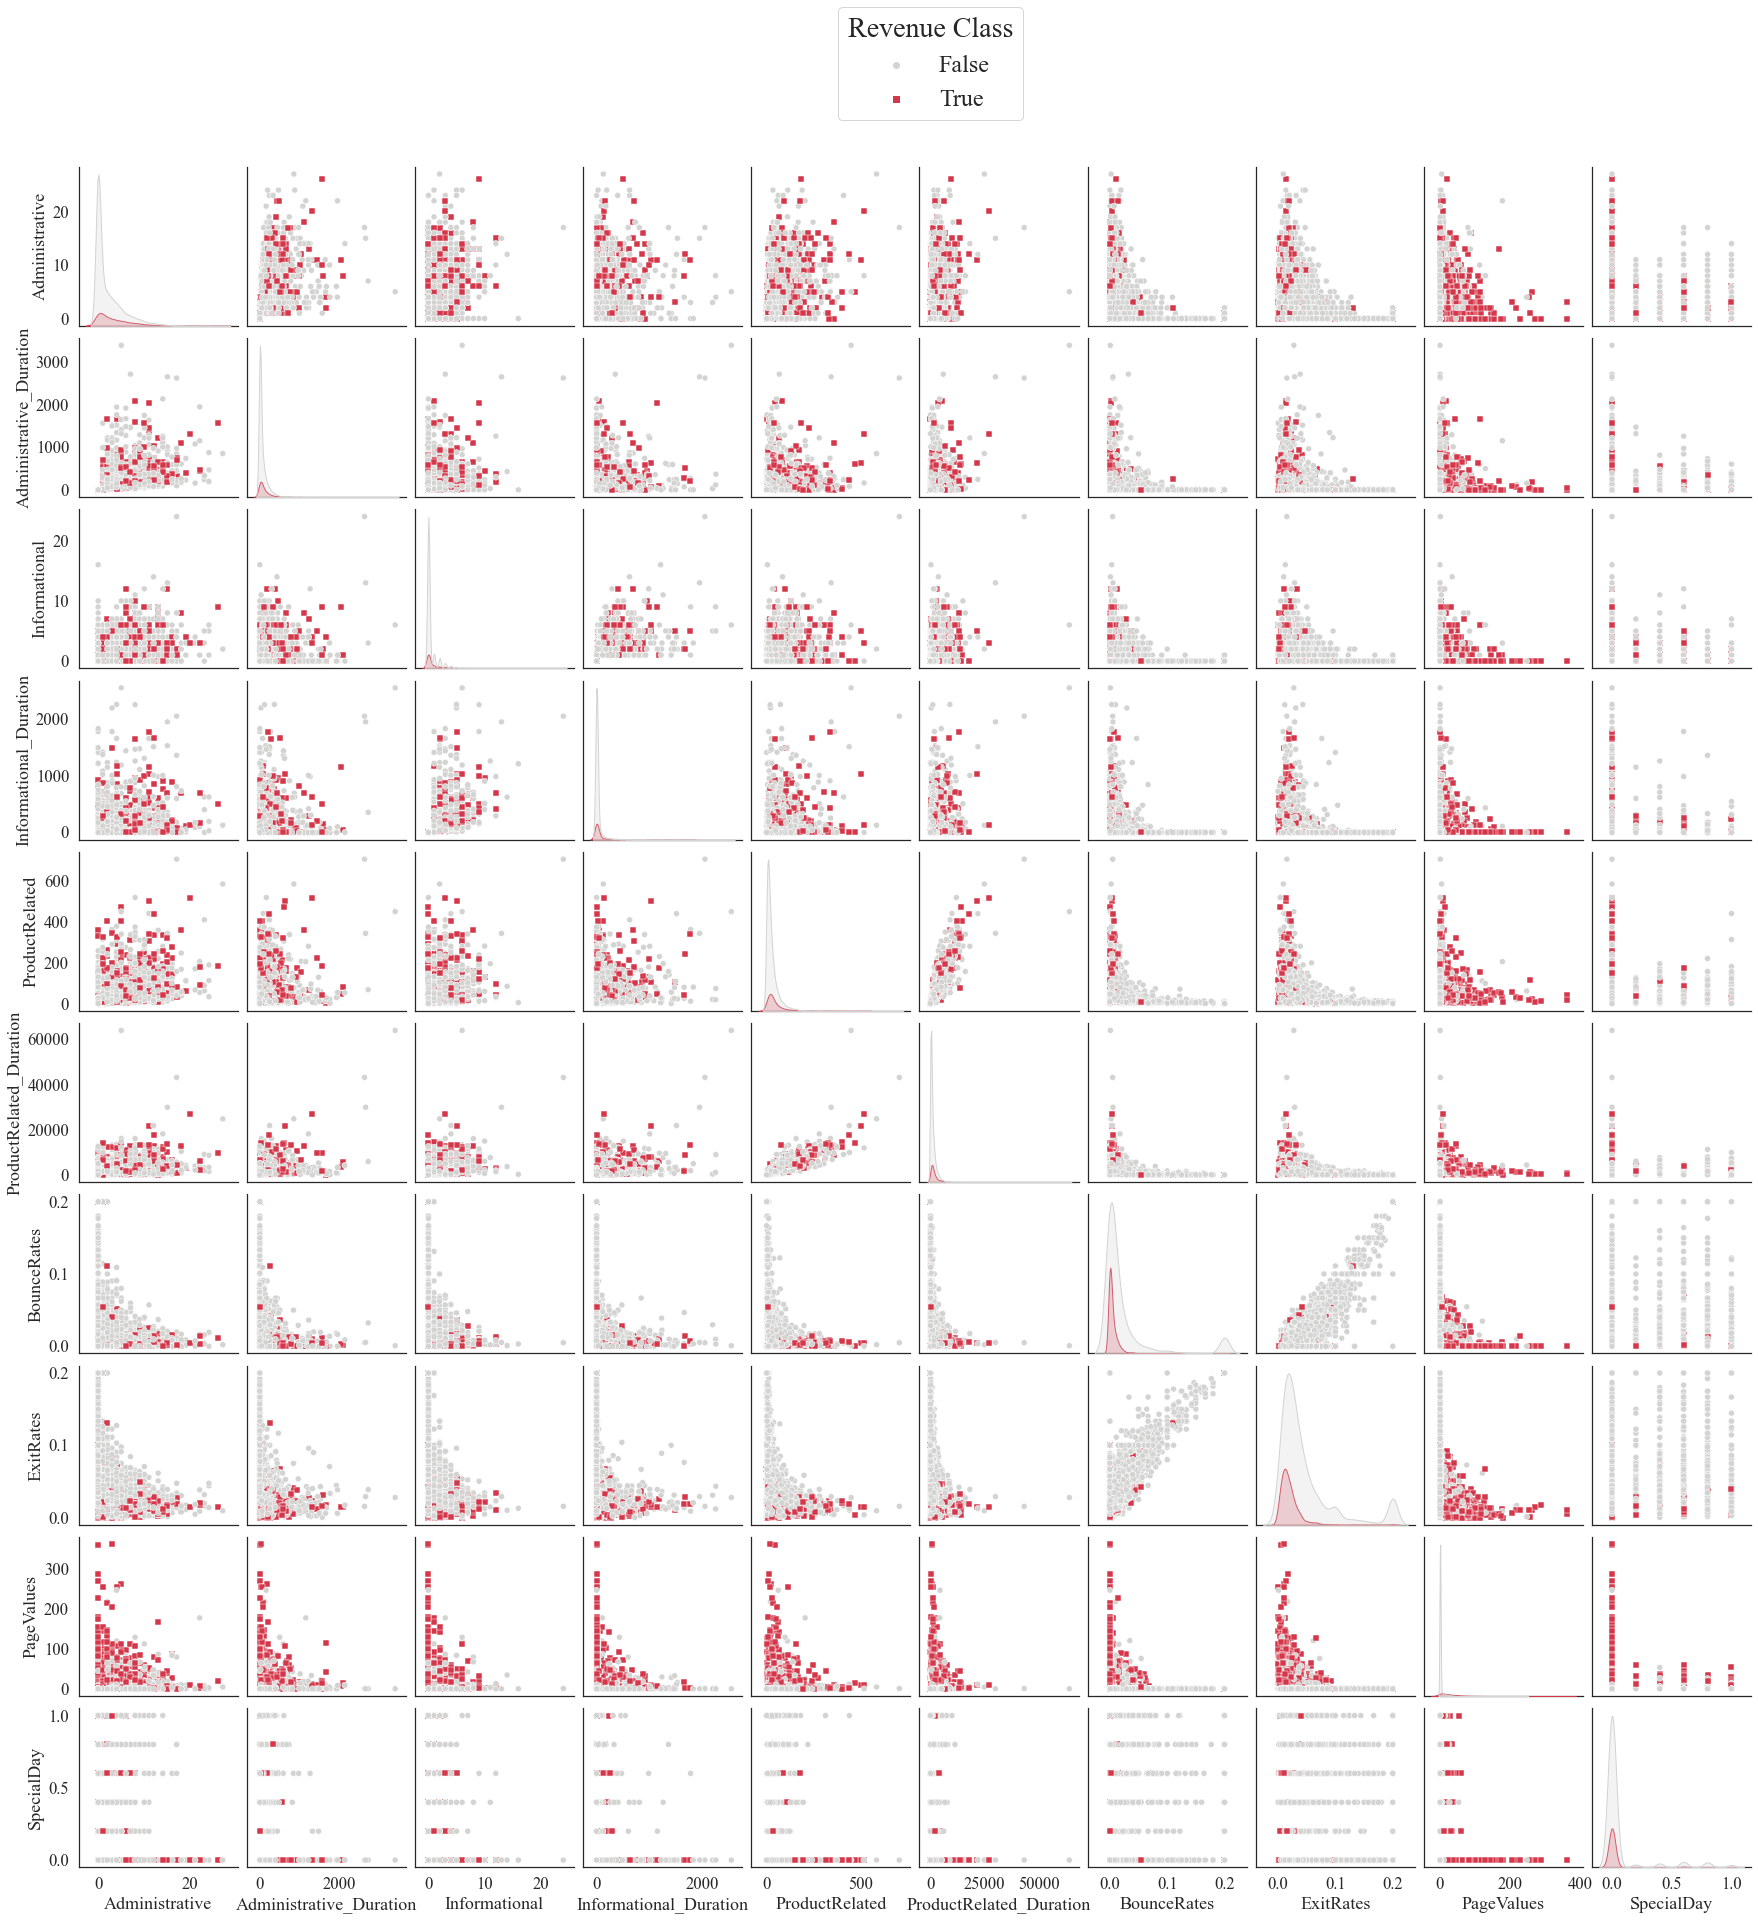

In [22]:
sns.set(style = "white", font_scale=1.5, font='Times New Roman')

pp = sns.pairplot(ecomm_train, hue='Revenue', vars=['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay'],markers=['o','s'], palette=['#d3d3d2', '#d4374a'])
pp._legend.remove()
plt.legend(fontsize=24, title_fontsize=28, bbox_to_anchor=(-4, 0., 0.5, 10.7), title="Revenue Class")

# plt.savefig('NumScatter', bbox_inches = "tight")

#### 2.2.2. Statistical Summary
Here we look at a basic summary of each feature to get a better understanding behind the numerical data, and to give us an idea of the scaling we will utilise. As can be observed the data has many outliers and standardisation appears to be favoured over normalisation.

In [23]:
print('\n\nSTATISTICAL INFORMATION ON THE E-COMMERCE DATA SET:\n',ecomm_train.describe())



STATISTICAL INFORMATION ON THE E-COMMERCE DATA SET:
        Administrative  Administrative_Duration  Informational  \
count     8631.000000              8631.000000    8631.000000   
mean         2.341907                82.379056       0.518712   
std          3.369312               181.170915       1.304450   
min          0.000000                 0.000000       0.000000   
25%          0.000000                 0.000000       0.000000   
50%          1.000000                 7.500000       0.000000   
75%          4.000000                94.000000       0.000000   
max         27.000000              3398.750000      24.000000   

       Informational_Duration  ProductRelated  ProductRelated_Duration  \
count             8631.000000     8631.000000              8631.000000   
mean                35.301906       31.913683              1199.319414   
std                144.430944       44.941882              1971.685392   
min                  0.000000        0.000000                 0

#### 2.2.3. Numerical Feature Relevance
To analysis numerical features we will utilise the SelectKBest functionality from Scikit-Learn, using both the Kendall Tau Coefficient and the ANOVA F-Classification. The features numbers represent the following features from the training dataset:
- Feature 0: `Administrative`
- Feature 1: `Administrative Duration`
- Feature 2: `Informational`
- Feature 3: `Informational Duration`
- Feature 4: `Product Related`
- Feature 5: `Product Related Duration`
- Feature 6: `Bounce Rates`
- Feature 7: `Exit Rates`
- Feature 8: `Page Values`
- Feature 9: `Special Day`

In [24]:
from sklearn.feature_selection import SelectKBest

# Create two seperate dataframes to deal with Numerical and Categorical Data Seperately
ecomm_train_n = ecomm_train[['Administrative', 'Administrative_Duration', 'Informational',
                             'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
                             'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']]

##### 2.2.3.1. Kendall Tau Coefficient
Kendals Rank Coefficient is a test of independence and a measure of the strength of dependence between two variables. The blow table shows the Kendal Rank correlation and the associated P-value. 

In [25]:
from scipy.stats import kendalltau

kc_dic = {}
ecomm_train_n = ecomm_train[['Administrative', 'Administrative_Duration', 'Informational',
                             'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
                             'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay','Revenue']]

for feature in ecomm_train_n:
    kc_dic[feature] = kendalltau(ecomm_train_n[feature], ecomm_train_n['Revenue'])
    
kc_df = pd.DataFrame.from_dict(kc_dic, orient='index')
kc_df['correlation'] = round(kc_df['correlation'],2)
kc_df = kc_df.sort_values(['correlation'], ascending=False)
kc_df

,correlation,pvalue
Revenue,1.00,0.000000e+00
PageValues,0.60,0.000000e+00
ProductRelated_Duration,0.18,1.381530e-97
ProductRelated,0.17,4.507980e-79
Administrative,0.16,1.196774e-60
Administrative_Duration,0.15,3.858170e-59
Informational,0.11,1.068250e-25
Informational_Duration,0.11,4.717896e-25
SpecialDay,-0.09,3.131174e-17
BounceRates,-0.13,1.091590e-44


##### 2.2.3.2. ANOVA  F-STATISTIC
Using this methodology calculates and F-Statistic, which indicates the ratio variance between two variables.

Feature 0:
	F-Score: 183.914469
	P-Value: 1.7988374852017593e-41
Feature 1:
	F-Score: 87.597265
	P-Value: 1.0056534192569041e-20
Feature 2:
	F-Score: 81.002825
	P-Value: 2.7353203494363766e-19
Feature 3:
	F-Score: 38.895254
	P-Value: 4.681806779975061e-10
Feature 4:
	F-Score: 238.585786
	P-Value: 4.0952248687902855e-53
Feature 5:
	F-Score: 226.130562
	P-Value: 1.8080725806265864e-50
Feature 6:
	F-Score: 204.839286
	P-Value: 6.14713950783554e-46
Feature 7:
	F-Score: 401.342605
	P-Value: 2.657790177892618e-87
Feature 8:
	F-Score: 2817.476001
	P-Value: 0.0
Feature 9:
	F-Score: 64.801649
	P-Value: 9.38369043631364e-16
Feature 10:
	F-Score: inf
	P-Value: 0.0


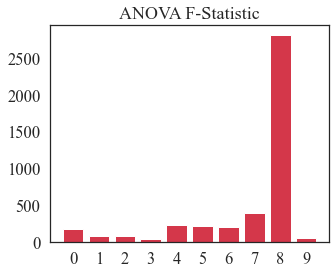

In [26]:
from sklearn.feature_selection import f_classif


# Here we use the 'chi2' functionality to determine the most relevant features
fs_n = SelectKBest(score_func=f_classif, k='all')
fs_n.fit_transform(ecomm_train_n, y_train)

# Creating a grapical representation
for i in range(len(fs_n.scores_)):
    print('Feature %d:' % (i))
    print('\tF-Score: %f' % (fs_n.scores_[i]))
    print('\tP-Value:', (fs_n.pvalues_[i]))
    
    
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 14

fig, ax = plt.subplots(1, 1, figsize=(5,4))

ax.bar([i for i in range(len(fs_n.scores_))], fs_n.scores_, color='#d4374a')
ax.set_title('ANOVA F-Statistic')
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9])

plt.show()
# fig.savefig('FStatistic', bbox_inches = "tight")

## 3. Data Pre-Processing
### 3.1. Preparing The Data
Data is pre-processed with the following considerations:
- The data provided does not have any missing values, however an imputer was used for the sake of future proofing the process, should there be any missing values used in the future.
- A standard scaler was used on all numerical features (other than `SpecialDay`) due to the presence of outliers in the data, as seen in section 2.2.2 above.
- The feature `SpecialDay` was normalised with the MinMaxScaler as data in this attribute exists within the range [0,1] Essentially leaving the data unchanged,
- Binary encoding was used to encode the categorical features. This method can be used for nominal data and roughly 67% all of the categorical features have 6 or more categories. Using a OneHotEncoder on all categorical features would double the dimensionality of the data.

In [27]:
from sklearn.pipeline import Pipeline 
from sklearn.impute import SimpleImputer # This class is imported incase any Nan Data is used in future instances
from sklearn.preprocessing import StandardScaler, MinMaxScaler # We use a standard scaler to account for the outliers in the numerical data
import category_encoders as ce
from sklearn.compose import ColumnTransformer


# Tranformation of Categorical Features Using a Binary Encoder
cat_feat = ['OperatingSystems','Browser','Region','VisitorType','Month'] 
cat_trans = Pipeline(steps = [
    ('imputer_cat_b', SimpleImputer(strategy='most_frequent')),
    ('catencoder', ce.BinaryEncoder())
])

# Tranform Numerical Features With Standardisation
num_feat_s = ['Administrative','Administrative_Duration','Informational','Informational_Duration','ProductRelated','ProductRelated_Duration','BounceRates', 'ExitRates','PageValues','SpecialDay']
num_trans_s = Pipeline(steps = [
    ('imputer_num_s', SimpleImputer(strategy='median')),
    ('scaler_s', StandardScaler()),
])

# Tranform Numerical Features With Normalisation
num_feat_n = ['SpecialDay']
num_trans_n = Pipeline(steps = [
    ('imputer_num_n', SimpleImputer(strategy='median')),
    ('scaler_n', MinMaxScaler()),
])

# Combine into A Single Column Transformer
preproccesor = ColumnTransformer (transformers = [
    ('categoricals', cat_trans, cat_feat),
    ('numericals_s', num_trans_s, num_feat_s),
    ('numericals_n', num_trans_n, num_feat_n),
], remainder = 'drop')

### 3.2. Principle Component Analysis
Here we conduct a principle component analysis on the processed data to  get an idea of the relationship between cardinality and explained variance that applies to the processed e-commerce data.

Text(0.5, 1.0, 'Data Dimension Analysis')

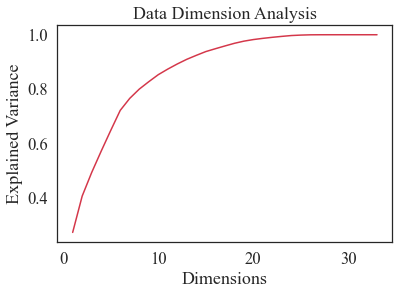

In [28]:
from sklearn.decomposition import PCA

# Tranforming the training data
xtrain = preproccesor.fit_transform(x_train)
pca = PCA()
pca.fit(xtrain)

#Plotting the PCA curve
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 14

cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, cumsum.shape[0] + 1), cumsum, color='#d4374a')

plt.xlabel('Dimensions')
plt.ylabel('Explained Variance')
plt.title('Data Dimension Analysis')

# plt.savefig('PCA', bbox_inches = "tight")

## 4. Model Implementation

### 4.1. Classification Models
Below we set up the selected models and import the relevant functions.

In [29]:
from sklearn.decomposition import PCA
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


# Create Logistical Model object
logRegModel = LogisticRegression(C=10, fit_intercept=False, max_iter=10,n_jobs=-1)

# Create Support Vector Machine Model object
svmModel = SVC(kernel = 'poly',degree=2, gamma='auto',decision_function_shape='ovo', class_weight='balanced',coef0=0.2, shrinking=False)

# Create Random Forest Classifier Model object
rfModel = RandomForestClassifier(ccp_alpha=0, criterion='entropy', max_depth=40,
                                 max_features='sqrt', max_samples=11000,
                                 min_impurity_decrease=0.001, min_samples_leaf=20,
                                 min_weight_fraction_leaf=0, n_estimators=500, n_jobs=-1,
                                 oob_score=True)

#### 4.1.1. Logistic Regression Model
Below we create the logistic model as well as including:
- SMOTE to account for the imbalanced data.
- Polynomial Features at the second degree to account for the lack of linear relationships that were observed in the pariplot of the visual inspection in section 2.2.2.
- Principal Component Analysis, to ensure that feature selection occurs with minimal loss of information, keeping in line with our acceptable confidence level of 95%.

In [30]:
# Create Logistical Regression Classification object
logRegClassifier = Pipeline(steps = [
    ('preprocessing_LR', preproccesor),
    ('polynomial_LR', PolynomialFeatures(degree=2)),
    ('pca_LR', PCA(n_components=0.95)),
    ('smote_LR', SMOTE(sampling_strategy='minority', k_neighbors=5)),
    ('classifier_LR', logRegModel)
])

# Save Fitted Logistical Model to logReg object
logReg = logRegClassifier.fit(x_train, y_train)

#### 4.1.2. Support Vector Machine Model
Below we create a Support Vector Machine model with the following considerations:
- SMOTE to account for the imbalanced data.

In [31]:
# Creating Support Vector Machine Classification object 
svmClassifier = Pipeline(steps = [
    ('preprocessing_SVM', preproccesor),
    ('smote_SVM', SMOTE(sampling_strategy='minority', k_neighbors=5)),
    ('classifier_SVM', svmModel)
])

# Save Fitted Support Vector Machine Model to svm object
svm = svmClassifier.fit(x_train, y_train)

#### 4.1.3. Random Forest Classifier
The Random Forrest classifier is an ensemble type classifier that makes use of the Decision Tree model. This approach does not require as much data pre-processing, however we will be using the pre-processed data from above. The model is run with the following considerations:
-	SMOTE to account for the imbalanced data.

In [32]:
# Create Decision Tree Classifier object
rfClassifier = Pipeline(steps = [
    ('preprocessing_rf', preproccesor),
    ('smote_rf', SMOTE(sampling_strategy='minority', k_neighbors=5)),
    ('classifier_rf', rfModel)
])

# Save Fitted Decision Tree Model to dT object
rf = rfClassifier.fit(x_train, y_train)

# Calculate oob score for reference when testing the model
data_pp = Pipeline(rfClassifier.steps[:-1])
x_train_sam, y_train_sam = data_pp.fit_resample(x_train, y_train)
rf_test = rfModel.fit(x_train_sam, y_train_sam)
print('Random Forest oob score: ',rf_test.oob_score_)

Random Forest oob score:  0.8948820526969237


### 4.2. Hyperparameter Optimisation
To better select the hyperparameters for each model we need to test each model with various hyperparameters. the hyperparameters for each model have been commented out and need to be uncommented depending on the model you select to analyse. You can change the target score as desire, however for the purpose of this analyses precision, accuracy, and ROC were concentrated on.

In [37]:
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, RandomizedSearchCV

scr = 'roc_auc' # CHANGE SCORE THE TEST MUST FOCUS ON
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3) # ADJUST NUMBER OF STRATIFIED FOLDS
model_CV = logRegModel # CHANGE THE OBJECT YOU WISH TO TEST HERE

# # Logistic Regression Parameter Dictionary
# param_dict ={
#     'penalty':['l1','l2','elasticent','none'],
#     'dual':[True, False],
#     'tol':[1e-2, 1e-3, 1e-4],
#     'C':[1e-4, 1, 25, 50, 100, 200],
#     'fit_intercept':[True, False],
#     'intercept_scaling':[0, 1, 4, 10, 20],
#     'class_weight':['balanced', None],
#     'solver':['newton-cg', 'lbfgs', 'liblinear','sag','saga'],
#     'max_iter':[10, 50, 100, 300, 600],
#     'multi_class':['auto', 'ovr', 'multinomial'],
#     'warm_start': [True, False],
#     'n_jobs':[-1, -0.5, 0, 0.5, 1],
#     'l1_ratio': [None, 0, 0.3, 0.6, 0.9, 1],
# }

# # Support Vector Machine Parameter Dictionary
# param_dict ={
#     'C':[0, 10, 20, 50, 100, 200],
#     'kernel':['linear','poly','rbf','sigmoid'],
#     'degree':[1,2,3],
#     'gamma':['scale', 'auto', 1, 5, 10],
#     'coef0':[0, 1, 2, 5],
#     'shrinking':[True, False],
#     'probability':[True, False],
#     'tol':[1e-5, 1e-2, 1, 3],
#     'cache_size':[100, 200, 300],
#     'class_weight':['balanced', None, 1],
#     'max_iter': [-1, 50, 200],
#     'decision_function_shape':['ovo', 'ovr'],
#     'break_ties': [False, True],
# }

# # Random Forrest Parameter Dictionary
# param_dict ={
#     'n_estimators':[10,50,100,150],
#     'criterion':['gini','entropy'],
#     'max_depth':[2, 3, 4, 5, 6],
#     'min_samples_split':[2,3],
#     'min_samples_leaf':[1, 10, 50, 100],
#     'min_weight_fraction_leaf':[0, 0.2, 0.5, 1, 2],
#     'max_features':['auto', 'sqrt','log2', None],
#     'max_leaf_nodes':[None, 5, 10, 20],
#     'min_impurity_decrease':[0.01, 0.1, 0.2],
#     'bootstrap':[True, False],
#     'oob_score':[True, False],
#     'n_jobs':[-1,0,1],
#     'warm_start':[False, True],
#     'class_weight':['balanced','balanced_subsample', None],
#     'ccp_alpha': [0.1, 0.3, 0.5],
#     'max_samples':[None,500,1500]
# }

# Getting the processed and balanced data for hyperparamter optimisation
hyperParam = Pipeline(steps = [
    ('preprocessing_opt', preproccesor),
    ('smote_opt', SMOTE(sampling_strategy='minority', k_neighbors=5)),
])

x_train_sam, y_train_sam = hyperParam.fit_resample(x_train, y_train)

#### 4.2.1. Random Search Analysis
Conduct a random search so to efficiently test the hyperparameters. This methodology allows us to investigate the various parameters without being too computationally expensive.

In [17]:
n_iterations = 1000 # ADJUST ME
n_jobs = 1 # ADJUST ME

# Run the Rand Search Analysis
rand_search = RandomizedSearchCV(model_CV, param_dict, n_iter = n_iterations, scoring=scr, n_jobs=n_jobs, cv=cv, refit=True)
rand_search.fit(x_train_sam, y_train_sam)

# Display Results
print('BEST ',scr,' SCORES:\n',rand_search.best_score_)
print('\nBEST PARAMETERS:\n',rand_search.best_params_)
print('\nBEST ESTIMATORS:\n',rand_search.best_estimator_)

BEST  roc_auc  SCORES:
 0.911096301863753

BEST PARAMETERS:
 {'warm_start': True, 'tol': 0.0001, 'solver': 'lbfgs', 'penalty': 'none', 'n_jobs': -1, 'multi_class': 'multinomial', 'max_iter': 10, 'l1_ratio': 0.3, 'intercept_scaling': 20, 'fit_intercept': True, 'dual': False, 'class_weight': None, 'C': 100}

BEST ESTIMATORS:
 LogisticRegression(C=100, intercept_scaling=20, l1_ratio=0.3, max_iter=10,
                   multi_class='multinomial', n_jobs=-1, penalty='none',
                   warm_start=True)


#### 4.2.2. Grid Search Analysis
Once we have conducted a random search, we will have a better understanding of the hyperparameters that have a large impact on the model’s performance. Then, using this information we can conduct a grid search analysis which will allow us to fine tune the hyperparameters that were highlighted in the Random Search analysis.

In [38]:
param_dict_gs ={
    # Insert the hyperparameters you wish to fine tune and experiment with
}

# Perorm Grid Search
grid_search = GridSearchCV(model_CV, param_dict_gs, scoring=scr, cv=cv, return_train_score=True)
grid_search.fit(x_train_sam, y_train_sam)

# Display Results
print('BEST ',scr,' SCORES:\n',grid_search.best_score_)
print('\nBEST PARAMETERS:\n',grid_search.best_params_)
print('\nBEST ESTIMATORS:\n',grid_search.best_estimator_)

BEST  roc_auc  SCORES:
 0.9208251577504731

BEST PARAMETERS:
 {}

BEST ESTIMATORS:
 LogisticRegression(C=10, fit_intercept=False, max_iter=10, n_jobs=-1)


### 4.3 Trained Model Test
Once we have determined the most suitable hyperparameters, we can conduct various tests on the predictions of the model based of the training data. This will give us a very rough (and possible biased) indication of how well we can expect our model to perform.

CONFUSION MATRIX:
                 PREDICTED         
                 Negative Positive
ACTUAL Negative      6484      765
       Positive       342     1040


CLASSIFICATION REPORT:
               precision    recall  f1-score   support

       False       0.95      0.89      0.92      7249
        True       0.58      0.75      0.65      1382

    accuracy                           0.87      8631
   macro avg       0.76      0.82      0.79      8631
weighted avg       0.89      0.87      0.88      8631



CROSS VALIDATION SCORES:
       accuracy  precision    recall        f1   roc_auc
0     0.873770   0.575145  0.736462  0.641148  0.898357
1     0.861530   0.553191  0.739130  0.634969  0.911622
2     0.882387   0.596154  0.786232  0.669767  0.907824
3     0.874276   0.573727  0.782609  0.660465  0.900670
4     0.877752   0.598870  0.750903  0.655172  0.898044
MEAN  0.873943   0.579417  0.759067  0.652305  0.903303


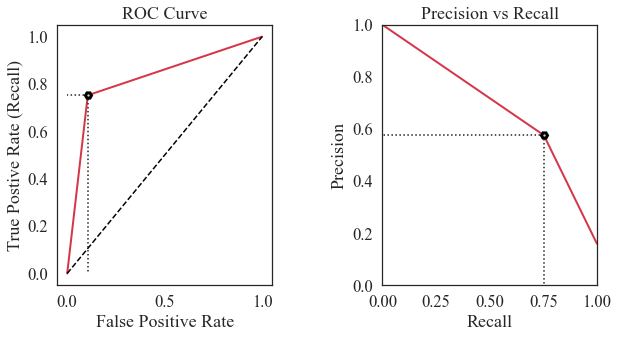

In [40]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score, precision_recall_curve, roc_curve 

model = svmClassifier # CHANGE TO THE MODEL YOU WISH TO TEST
cv = 5 # ADJUST THE NUMBER OF FOLDS TO TEST ON

# Cross validation predictor and creating the associatted feedback
y_train_cvpred = cross_val_predict(model, x_train, y_train, cv=cv)
hori = pd.MultiIndex.from_product([['PREDICTED'],['Negative','Positive']])
vert = pd.MultiIndex.from_product([['ACTUAL'],['Negative','Positive']])
cm = confusion_matrix(y_train, y_train_cvpred)
cvpred_cm = pd.DataFrame(cm, columns= hori, index=vert)
cr = classification_report(y_train, y_train_cvpred)

# Cross validation scores in each metric
cross_val_dic ={}
for score in ['accuracy','precision','recall','f1','roc_auc']:
    cross_val_dic[score] = cross_val_score(model, x_train, y_train, scoring=score, cv=cv)
cross_val_df = pd.DataFrame(cross_val_dic)
cross_val_df.loc['MEAN'] = cross_val_df.mean()

#Print the Scores
print('CONFUSION MATRIX:\n', cvpred_cm)
print('\n\nCLASSIFICATION REPORT:\n', cr)
print('\n\nCROSS VALIDATION SCORES:\n', cross_val_df)

# Plotting the results for visual representation
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 14

recall_rate = recall_score(y_train, y_train_cvpred)
precision_rate = precision_score(y_train, y_train_cvpred)
FP = cm[0][1]/sum(cm[0])
fpr, tpr, thresholds = roc_curve(y_train, y_train_cvpred)
precision, recall, thresholds_prc = precision_recall_curve(y_train, y_train_cvpred)

fig, ax = plt.subplots(1, 2, figsize=(10,6))
fig.tight_layout(pad=5)

ax[0].plot(fpr, tpr, linewidth=2, color='#d4374a',ls='-')
ax[0].plot([0,1], [0,1], color='black', ls='--')
ax[0].plot([FP,FP],[recall_rate,0], color='#22211f', ls=':')
ax[0].plot([FP, 0], [recall_rate,recall_rate], color='#22211f', ls=':')
ax[0].plot(FP, recall_rate, marker='H', markerfacecolor="#d3d3d2", markeredgewidth=3, markeredgecolor="black")
ax[0].set_title('ROC Curve')
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Postive Rate (Recall)')
    
ax[1].plot(recall, precision, linewidth=2,color='#d4374a',)
ax[1].plot([recall_rate,recall_rate],[precision_rate,0], color='#22211f', ls=':')
ax[1].plot([recall_rate, 0], [precision_rate,precision_rate], color='#22211f', ls=':')
ax[1].plot(recall_rate, precision_rate, marker='H', markerfacecolor="#d3d3d2", markeredgewidth=3, markeredgecolor="black")
ax[1].set_title('Precision vs Recall')
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_ylim([0.0, 1.0])
ax[1].set_xlim([0.0, 1.0])

plt.show()

## 5. Model Evaluation
This is the final stage where we test the model with unseen test data that we separated at the beginning of the analysis. This is essentially the ultimate test of our model and should only be conducted when we believe our model to be fully optimised.

CONFUSION MATRIX:
                 PREDICTED         
                 Negative Positive
ACTUAL Negative      2793      331
       Positive       129      446


CROSS VALIDATION PREDICTOR:
               precision    recall  f1-score   support

       False       0.96      0.89      0.92      3124
        True       0.57      0.78      0.66       575

    accuracy                           0.88      3699
   macro avg       0.76      0.83      0.79      3699
weighted avg       0.90      0.88      0.88      3699



ACCURACY:  0.8756420654230873

Precision:  0.574002574002574

Recall:  0.7756521739130435

F1:  0.6597633136094675

ROC AUC SCORE:  0.8348491343316818


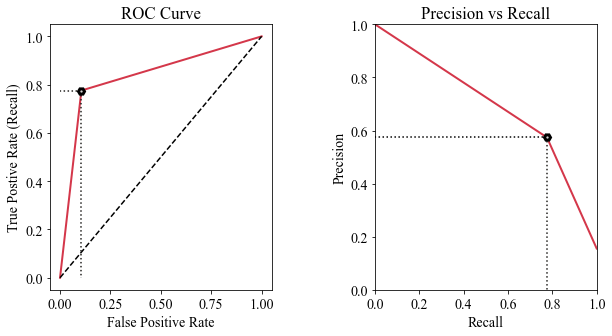

In [107]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score, recall_score, precision_score, accuracy_score, precision_recall_curve, roc_curve 

model =  lr # CHANGE THE MODEL TO THE RELEVANT MODEL HERE

# Use model to predict values on unseen test data
y_pred = model.predict(x_test) 


# Generating feedback
hori = pd.MultiIndex.from_product([['PREDICTED'],['Negative','Positive']])
vert = pd.MultiIndex.from_product([['ACTUAL'],['Negative','Positive']])
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, columns= hori, index=vert)
cr = classification_report(y_test, y_pred)
accuracy_ = accuracy_score(y_test, y_pred)
precision_rate = precision_score(y_test, y_pred)
recall_rate = recall_score(y_test, y_pred)
f1_ = f1_score(y_test, y_pred)
ROC_ = roc_auc_score(y_test, y_pred)

# Returning the relative evaluation scores to determine the predictability of the model
print('CONFUSION MATRIX:\n', cm_df)
print('\n\nCLASSIFICATION REPORT:\n', cr)
print('\n\nACCURACY: ', accuracy_)
print('\nPrecision: ', precision_rate)
print('\nRecall: ', recall_rate)
print('\nF1: ', f1_)
print('\nROC AUC SCORE: ', ROC_)


# Plotting the results from the test for visual representation
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 14

FP = cm[0][1]/sum(cm[0])
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
precision, recall, thresholds_prc = precision_recall_curve(y_test, y_pred)

fig, ax = plt.subplots(1, 2, figsize=(10,6))
fig.tight_layout(pad=5)

ax[0].plot(fpr, tpr, linewidth=2, color='#d4374a',ls='-')
ax[0].plot([0,1], [0,1], color='black', ls='--')
ax[0].plot([FP,FP],[recall_rate,0], color='#22211f', ls=':')
ax[0].plot([FP, 0], [recall_rate,recall_rate], color='#22211f', ls=':')
ax[0].plot(FP, recall_rate, marker='H', markerfacecolor="#d3d3d2", markeredgewidth=3, markeredgecolor="black")
ax[0].set_title('ROC Curve')
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Postive Rate (Recall)')
    
ax[1].plot(recall, precision, linewidth=2,color='#d4374a',)
ax[1].plot([recall_rate,recall_rate],[precision_rate,0], color='#22211f', ls=':')
ax[1].plot([recall_rate, 0], [precision_rate,precision_rate], color='black', ls=':')
ax[1].plot(recall_rate, precision_rate, marker='H', markerfacecolor="#d3d3d2", markeredgewidth=3, markeredgecolor="black")
ax[1].set_title('Precision vs Recall')
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_ylim([0.0, 1.0])
ax[1].set_xlim([0.0, 1.0])

plt.show()